In [1]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

![alternative text](../images/muograph_logo.png)


**<h1><center>POCA: tutorial</center></h1>**

The `POCA` class is used to compute the **Point of Closest Approach location**, from the **tracking information** provided by the `TrackingMST`.

### **I - Instanciation** 

First, let's instanciante the `TrackingMST` class. At first, we will consider a detector with perfect **spatial resolution** and **efficiency**:

In [2]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

from muograph.hits.hits import Hits

hits_in = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_in

GPU is not available. Using CPU
MPS is available. Using  mps


Collection of hits from 137,033 muons on 3 detector panels.

In [3]:
hits_out = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (3, 4, 5),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_out

Collection of hits from 137,033 muons on 3 detector panels.

In [4]:
from muograph.tracking.tracking import Tracking

tracks_in = Tracking(label="above", hits=hits_in)
tracks_out = Tracking(label="below", hits=hits_out)

tracks_in, tracks_out


/Users/vischia/workarea_temp/muography/muograph/tutorials/../muograph/tracking/tracking.py:167: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  _, _, vh = torch.linalg.svd(centered_hits_chunk, full_matrices=False)  # vh shape: (chunk_size, 3, 3)


(Collection of tracks from 137,033 muons 
  with perfect angular resolution.,
 Collection of tracks from 137,033 muons 
  with perfect angular resolution.)

In [5]:
output_dir = "../output_test/"
from muograph.tracking.tracking import TrackingMST
mst = TrackingMST(trackings=(tracks_in, tracks_out))
mst

Collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

The `POCA` class takes the following **arguments**:


- `tracking (Optional[TrackingMST])`: Instance of the TrackingMST class.

- `voi (Optional[Volume])`: Instance of the Volume class. If provided, muon events with poca locations outside the voi will be filtered out, the number of poca locations per voxel `n_poca_per_vox` as well as the voxel indices of each poca location will be computed.

- `poca_file (Optional[str])`: The path to the poca.hdf5 to load attributes from.

- `output_dir (Optional[str])`: Path to a directory where to save POCA attributes in a hdf5 file.

Let's instanciate the `POCA` class using an instances of `TrackingMST` and `Volume` class.

In [6]:
from muograph.volume.volume import Volume
voi = Volume(
    position = (0, 0, -1200), # The position of the Volume of interest.
    dimension = (1000, 600, 600), # The dimensions of the Volume of interest.
    voxel_width = 20) # The voxel size.

In [7]:
from muograph.reconstruction.poca import POCA
poca = POCA(tracking=mst, voi=voi, output_dir="../output_test/")

../output_test directory created


/Users/vischia/workarea_temp/muography/muograph/tutorials/../muograph/reconstruction/poca.py:238: UserWarning: MPS: nonzero op is not natively supported for the provided input on MacOS14Falling back on CPU. This may have performance implications.See github.com/pytorch/pytorch/issues/122916 for further info (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:309.)
  valid_indices = valid_voxels.nonzero(as_tuple=False)  # Shape: (num_valid_points, 4) - (batch_idx, x_idx, y_idx, z_idx)


Class attributes saved at ../output_test/poca.hdf5


### **II - POCA points**

When instanciated, the `POCA` class follows the following workflow:

 - **Remove** events with **parallel incoming** and **outgoing tracks**, as the closest point between two parallel lines is not defined.

 - Computes POCA locations.
  
 - **Remove events** with **POCAs outside** of the **volume of interest**, as they will not contribute to the scattering density inference.

The Point Of Closest Approach is **defined** as the **closest point between two straight lines** and is computed by the `POCA.compute_poca_points()` method.

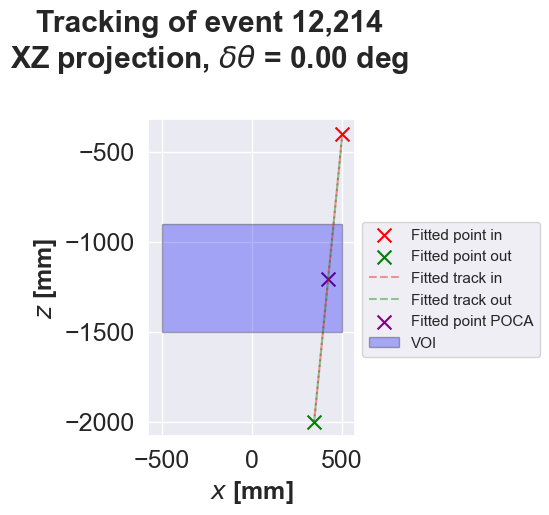

In [8]:
event = 12214

poca.plot_poca_event(
    event = event, 
    voi=voi, 
    proj="XZ",
    figname="../output_test/poca_event_display")

In [9]:
poca.poca_points, poca.poca_points.shape

(tensor([[   20.0162,    20.7572, -1303.3403],
         [  226.3104,    60.0073, -1209.2185],
         [  -34.8589,  -120.0502, -1301.7782],
         ...,
         [ -154.8845,    10.2384, -1256.0830],
         [  179.1328,   -60.0251, -1302.3774],
         [ -196.9560,   -13.7449, -1082.5769]], device='mps:0'),
 torch.Size([77047, 3]))

In [10]:
event = 12214
f"POCA location of event {event:,d} is x, y, z = {poca.poca_points[event, 0]:.1f}, {poca.poca_points[event, 1]:.1f}, {poca.poca_points[event, 2]:.1f} [mm]"

'POCA location of event 12,214 is x, y, z = 425.9, 22.6, -1203.8 [mm]'

By **removing events** with **parallel tracks** and **POCA locations** **outisde** of the volume of interest, approximatly **half** of the **events** **got discarded**!

In [11]:
mst, poca

(Collection of tracks from 137,033 muons 
  with perfect angular resolution.
  with perfect tracking efficiency,
 Collection of 77047 POCA locations.)

Let's **plot** the coordinates of the **POCA locations**:

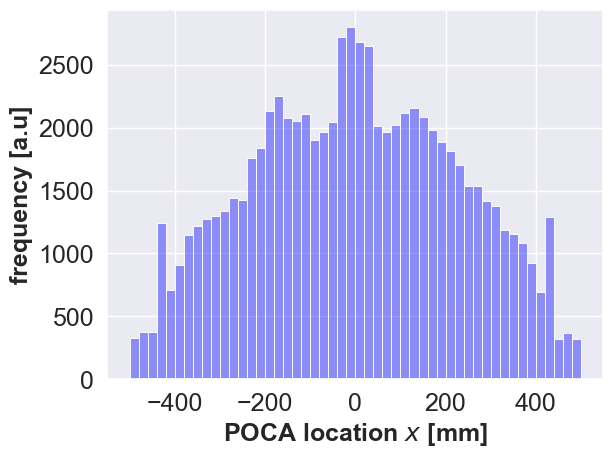

In [14]:
from muograph.plotting.plotting import plot_hist
import torch
plot_hist(poca.poca_points[:, 0] if poca.poca_points[:, 0].device == torch.device("cpu") else poca.poca_points[:, 0].cpu() , xlabel=r"POCA location $x$ [mm]")

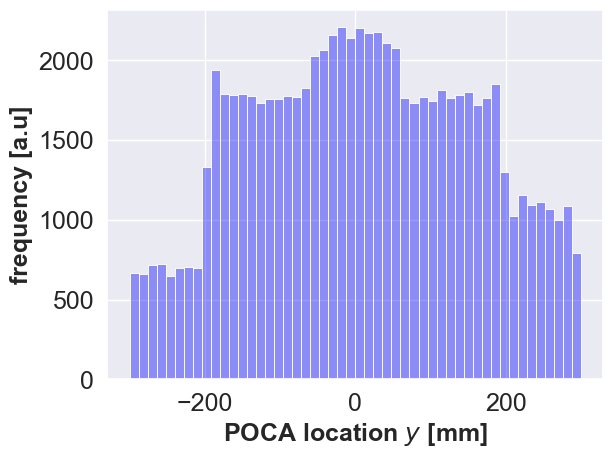

In [16]:
plot_hist(poca.poca_points[:, 1] if poca.poca_points[:, 1].device == torch.device("cpu") else poca.poca_points[:, 1].cpu(), xlabel=r"POCA location $y$ [mm]")

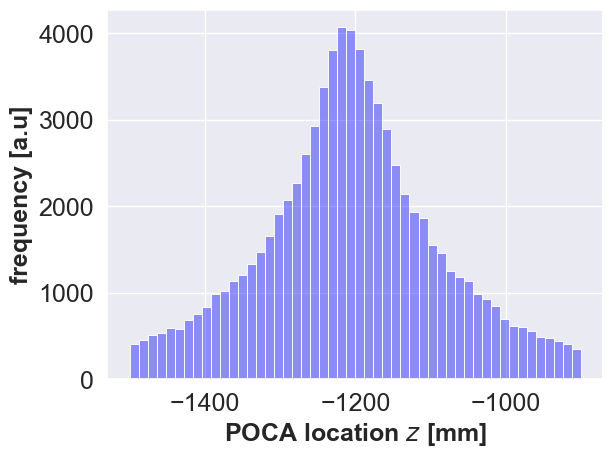

In [18]:
plot_hist(poca.poca_points[:, 2] if poca.poca_points[:, 2].device == torch.device("cpu") else poca.poca_points[:, 2].cpu(), xlabel=r"POCA location $z$ [mm]")

### **III - POCA points per voxel**

Once the **POCA locations** are computed, one computes the number of POCA per voxel: `n_poca_per_vox`.

It conviently produces a $(n_x, n_y, n_z)$ array of integers, where $n_i$ is the number of voxels along the $i$ direction.

In [19]:
poca.n_poca_per_vox, poca.n_poca_per_vox.shape

(tensor([[[2, 1, 0,  ..., 0, 1, 1],
          [1, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 1],
          [0, 0, 1,  ..., 0, 0, 0],
          [0, 1, 0,  ..., 0, 0, 1]],
 
         [[1, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 0, 0,  ..., 0, 0, 2],
          [1, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 2, 0,  ..., 0, 2, 1],
          [0, 2, 0,  ..., 2, 0, 0],
          [1, 2, 1,  ..., 0, 0, 0],
          ...,
          [0, 1, 0,  ..., 1, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0],
          [1, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 1,  ..., 0, 0, 1],
          [0, 0, 0,  ..., 0, 1, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 1, 1],
          [0, 0, 1,  ..., 0, 0, 1],
          [0, 0, 1,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 2, 0],
          [1

In [20]:
ix, iy, iz = 24, 15, 14
f"Voxel with indices {ix},{iy},{iz} contains {poca.n_poca_per_vox[ix, iy, iz]} poca points."

'Voxel with indices 24,15,14 contains 17 poca points.'

### **IV - Plotting voxelized density predictions**

The number of POCAs per voxel can be used to produce voxelized **scattering density predictions**.

The `POCA` class comes along a set of funtions to **plot voxelized scattering density predictions**, as it inherits from the `VoxelPlotting` class.

Let's plot the average number of **POCA points** along various projections using the `VoxelPlotting.plot_pred_slice()` function. 

The latter plots the number of POCA points per voxel as a **2D histogram** (center) as well as the **associated 1D histograms** (top and right).

##### **Plot XY projection**

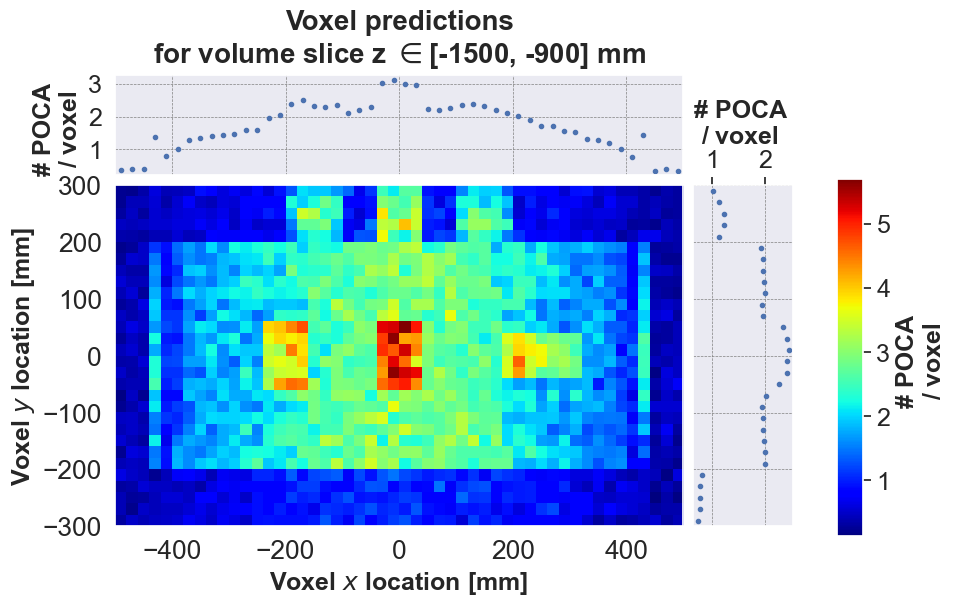

In [21]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2 

poca.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/n_poca_per_vox_all_volume", # The name of the figure to save
    pred_label="# POCA \n/ voxel",
    pred_unit="",
)

##### **Plot XZ projection**

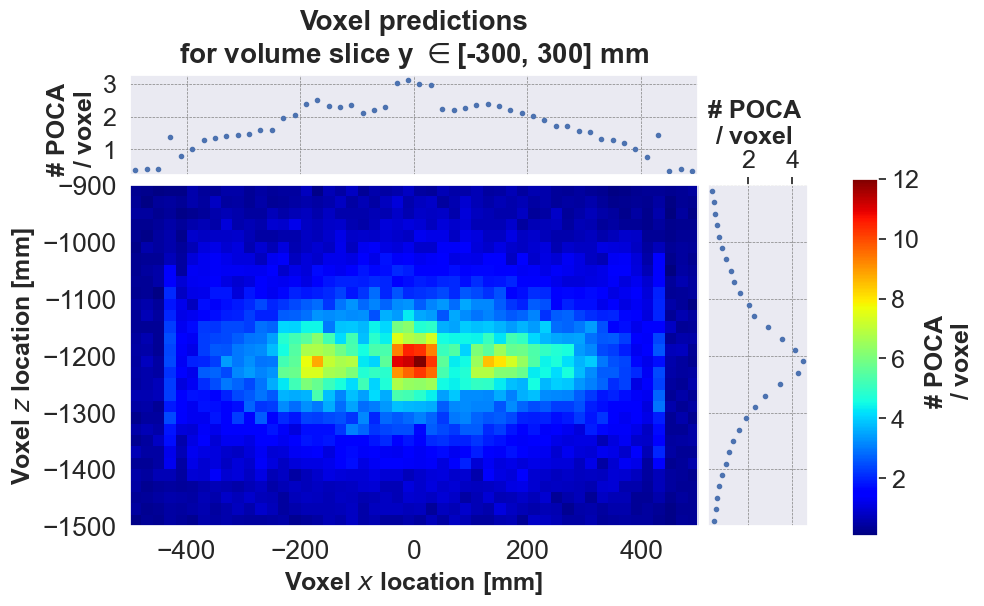

In [22]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 1

poca.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/n_poca_per_vox_all_volume", # The name of the figure to save
    pred_label="# POCA \n/ voxel",
    pred_unit="",
)

##### **Plot YZ projection**

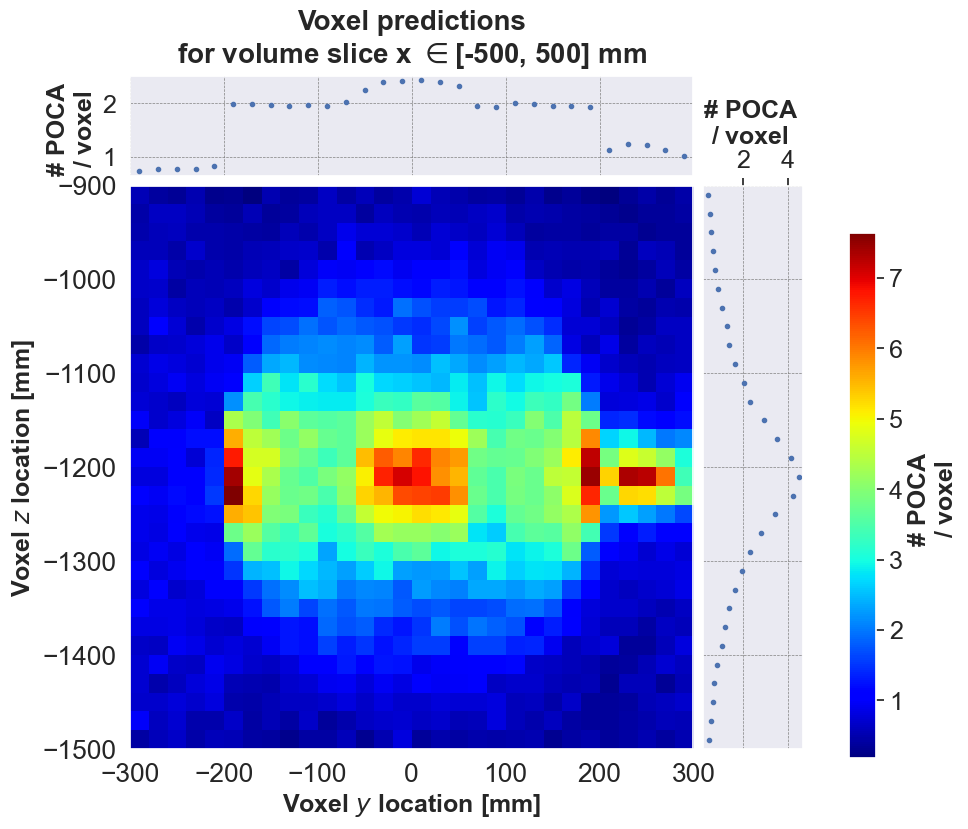

In [23]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 0

poca.plot_pred_slice(
    voi=voi,  # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]-1), # Choose a range of voxels to plot along the desired direction
    dim = dim, # The dimension to project along
    figname = "../output_test/n_poca_per_vox_all_volume", # The name of the figure to save
    pred_label="# POCA \n/ voxel",
    pred_unit="",
)

While **plotting** the number of **POCAs averaged** along a **direction** is **convenient** to get an idea of the reconstructed image as a whole, it is also meaningfull to plot the predictions by slices of voxels.

The `VoxelPlotting.plot_pred_by_slice` is designed to do so. Similarly to `VoxelPlotting.plot_pred_slice`, it plots voxelized predictions along a given projection:

In [24]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 2

poca.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="",
    pred_label="# POCA / voxel",
    figname = "../output_test/n_poca_per_vox_slice"
)


AssertionError: Make sure that the number of plots (31) can be divided by nslice_per_plot (2)

In [25]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 1

poca.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=4, # The number of columns of the plot
    pred_unit="",
    pred_label="# POCA / voxel",
    figname = "../output_test/n_poca_per_vox_slice"
)


AssertionError: Make sure that the number of plots (31) can be divided by nslice_per_plot (2)

In [26]:
# Choose a dimension to project along (0 = x, 1 = y, 2 = z)
dim = 0

poca.plot_pred_by_slice(
    voi=voi, # The volume of interest
    xyz_voxel_preds=poca.n_poca_per_vox,  # The voxelized predictions to plot
    voi_slice=(0, voi.n_vox_xyz[dim]), # Choose a range of voxels to plot along the desired direction
    dim=dim,  # The dimension to project along
    nslice_per_plot=2, # The number of slice per plot
    ncols=5, # The number of columns of the plot
    pred_unit="",
    pred_label="# POCA / voxel",
    figname = "../output_test/n_poca_per_vox_slice"
)


AssertionError: Make sure that the number of plots (51) can be divided by nslice_per_plot (2)